In [1]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

In [2]:
# 2.2.1
def RBFKernel(X1, X2, h, sigma):
    K = np.zeros((len(X2), len(X1)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            d = X1[i] - X2[j]
            K[j, i] = d @ d
            
    return sigma * np.exp(-K/2/h**2)

# 2.2.2
def GPRegression(XTrain, yTrain, XTest, gamma, h, sigma):
    n = len(XTrain)
    
    # K(x, x) - kernel over training data.
    K = RBFKernel(XTrain, XTrain, h, sigma)
    
    # Cholesky decomposition.
    L = np.linalg.cholesky(K + gamma*np.identity(n))
    
    # Solves K @ alpha = yTrain
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, yTrain))
    
    # K(x*, x) - kernel between train and test data.
    k = RBFKernel(XTrain, XTest, h, sigma)
    
    # If K @ alpha = yTrain, should have k @ alpha = yTest
    f = k @ alpha # mean
    
    # Compute variance, V = K(x*,x*) - K(x*,x) K(x,x)^-1 K(x,x*)
    v = np.linalg.solve(L, k.T) # Note, v.T @ v = k @ K^(-1) @ k.T
    V = RBFKernel(XTest, XTest, h, sigma) - v.T @ v
    
    # Log marginal likelihood.
    trace_log = np.sum(np.log(np.diagonal(L)))
    p = -0.5*yTrain.T @ alpha - trace_log - n/2 * np.log(2*np.pi)
    
    return f, V, p

def LogMarginalLikelihood(XTrain, yTrain, gamma, h, sigma):
    n = len(XTrain)
    K = RBFKernel(XTrain, XTrain, h, sigma)
    L = np.linalg.cholesky(K + gamma*np.identity(n))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, yTrain))
    trace_log = np.sum(np.log(np.diagonal(L)))
    
    # Ignore the -n/2 * np.log(2*np.pi) portion because it is constant.
    return -0.5*yTrain.T @ alpha - trace_log

def HyperParameters(XTrain, yTrain, hs, sigmas):
    gamma = 0.01 * np.std(yTrain)
    best = None
    likelihood = 0
    for h in hs:
        for sigma in sigmas:
            l = LogMarginalLikelihood(XTrain, yTrain, gamma, h, sigma)
            if best is None or l > likelihood:
                best = (h, sigma)
                likelihood = l
    return gamma, *best

"""
XTrain = np.array([[1, 2], [2, 3], [3, 4]])
yTrain = np.array([1, 2, 3])
XTest = np.array([[10, 9], [2, 4]])

hs = np.logspace(-1, 1, 10) * np.std(XTrain)
sigmas = np.logspace(-1, 1, 10) * np.std(yTrain)

gamma, h, sigma = HyperParameters(XTrain, yTrain, hs, sigmas)
GPRegression(XTrain, yTrain, XTest, gamma, h, sigma)
""";

In [3]:
# Get data.
with open("concrete.mat", "r") as f:
    data = f.read()

d = dict()
for line in data.split("\n"):
    if "# name:" in line:
        name = line.split()[-1]
        d[name] = []
    if "#" in line:
        continue
    if len(line) == 0:
        continue
    d[name].append([*map(float, line.split())])
    if len(d[name][-1]) == 1:
        d[name][-1] = d[name][-1][0]
d = dict((k, np.array(v)) for k, v in d.items())

XTrain = d["XTrain"]
yTrain = d["yTrain"]
XTest = d["XTest"]
yTest= d["yTest"]

In [4]:
hs = np.logspace(-1, 1, 10) * np.std(XTrain)
sigmas = np.logspace(-1, 1, 10) * np.std(yTrain)

gamma, h, sigma = HyperParameters(XTrain, yTrain, hs, sigmas)
guess, var, p = GPRegression(XTrain, yTrain, XTest, gamma, h, sigma)

In [5]:
print(gamma, h, sigma)

0.16646411925609453 35.39233964286505 166.46411925609453


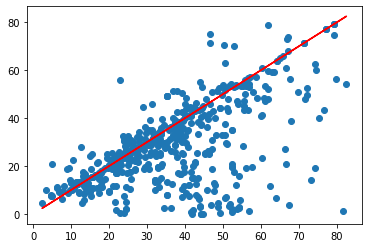

In [6]:
plt.plot(yTest, yTest, color="red")
plt.scatter(yTest, guess)
plt.show();

In [7]:
# Better HyperParameter finding. Uses a terrible implementation
# of gradient descent.
def hyper(XTrain, yTrain, g=10, h=100, s=50, eps=[1, 10, 10]):
    eps_ = eps[:]
    f = lambda g,h,s: LogMarginalLikelihood(XTrain, yTrain, g, h, s)
    for i in range(10):
        fghs = f(g, h, s)
        dg = logsumexp([f(g+0.1, h, s), fghs], b=[1,-1]) - fghs
        dh = logsumexp([f(g, h+0.1, s), fghs], b=[1,-1]) - fghs
        ds = logsumexp([f(g, h, s+0.1), fghs], b=[1,-1]) - fghs
        g += eps[0] * dg
        h += eps[1] * dh
        s += eps[2] * ds
        eps[0] = max(eps_[0], abs(dg))
        eps[1] = max(eps_[1], abs(dh))
        eps[2] = max(eps_[2], abs(ds))
    return g, h, s

In [8]:
gamma, h, sigma = hyper(XTrain, yTrain)
guess, var, p = GPRegression(XTrain, yTrain, XTest, gamma, h, sigma)

In [9]:
print(gamma, h, sigma)

19.196479140186703 92.0685948294522 65.2125045404182


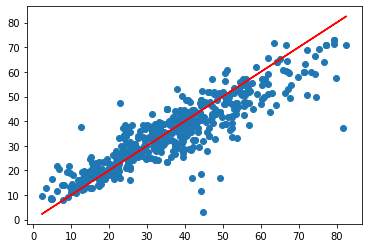

In [10]:
plt.plot(yTest, yTest, color="red")
plt.scatter(yTest, guess)
plt.show();